#  <span style="color:orange">Pycaret usando a base de dados do projeto</span>

# Carregando os dados

In [3]:
import pandas as pd
df = pd.read_feather('credit_scoring.ftr')

In [4]:
df.shape

(750000, 15)

In [5]:
df.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')

In [6]:
dataset = df.sample(50000)

In [7]:
dataset.drop(['data_ref','index'], axis=1, inplace=True)

In [8]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


In [9]:
from pycaret.classification import *

# Configurando o pycaret

In [10]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.7%


In [11]:
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [12]:
#forçando a variável qnt de filhos como numérica
data.qtd_filhos = data.qtd_filhos.astype(float)

In [13]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.7%


# Comparando todos os modelos

In [14]:
best_model = compare_models(fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9221,0.7679,0.0223,0.5749,0.0426,0.0370,0.0994,0.4800
lr,Logistic Regression,0.9217,0.7669,0.0000,0.0000,0.0000,0.0000,0.0000,2.0810
ridge,Ridge Classifier,0.9217,0.6381,0.0000,0.0000,0.0000,0.0000,0.0000,0.1090
lda,Linear Discriminant Analysis,0.9217,0.6380,0.0000,0.0000,0.0000,0.0000,0.0000,0.1710
dummy,Dummy Classifier,0.9217,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0970
gbc,Gradient Boosting Classifier,0.9216,0.7716,0.0192,0.4750,0.0369,0.0310,0.0826,0.8870
lightgbm,Light Gradient Boosting Machine,0.9214,0.7581,0.0184,0.4337,0.0352,0.0293,0.0756,0.3130
catboost,CatBoost Classifier,0.9198,0.7539,0.0357,0.3763,0.0651,0.0522,0.0955,7.5880
knn,K Neighbors Classifier,0.9140,0.6388,0.0642,0.2846,0.1045,0.0780,0.1027,1.0710
svm,SVM - Linear Kernel,0.9011,0.7737,0.1939,0.2391,0.2107,0.1672,0.1697,0.1480


In [15]:
#ordenando a tabela por AUC
best_model = compare_models(fold=10, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9011,0.7737,0.1939,0.2391,0.2107,0.1672,0.1697,0.1200
gbc,Gradient Boosting Classifier,0.9216,0.7716,0.0192,0.4750,0.0369,0.0310,0.0826,0.8140
ada,Ada Boost Classifier,0.9221,0.7679,0.0223,0.5749,0.0426,0.0370,0.0994,0.3660
lr,Logistic Regression,0.9217,0.7669,0.0000,0.0000,0.0000,0.0000,0.0000,0.9750
lightgbm,Light Gradient Boosting Machine,0.9214,0.7581,0.0184,0.4337,0.0352,0.0293,0.0756,0.2490
catboost,CatBoost Classifier,0.9198,0.7539,0.0357,0.3763,0.0651,0.0522,0.0955,7.1440
rf,Random Forest Classifier,0.9002,0.7037,0.0880,0.1952,0.1211,0.0763,0.0832,0.6570
nb,Naive Bayes,0.6370,0.6815,0.6308,0.1289,0.2140,0.0965,0.1483,0.1030
qda,Quadratic Discriminant Analysis,0.1848,0.6654,0.9839,0.0865,0.1590,0.0177,0.0862,0.1450
knn,K Neighbors Classifier,0.9140,0.6388,0.0642,0.2846,0.1045,0.0780,0.1027,0.3210


In [16]:
print(best_model)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


# Criando um modelo

In [17]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


### 8.3 Gradient Boosting Classifier

In [18]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9203,0.7583,0.0154,0.3077,0.0293,0.0220,0.0536
1,0.9218,0.7823,0.0192,0.5000,0.0370,0.0314,0.0863
2,0.9227,0.7565,0.0269,0.6364,0.0517,0.0456,0.1198
3,0.9218,0.7690,0.0192,0.5000,0.0370,0.0314,0.0863
4,0.9203,0.7674,0.0154,0.3077,0.0293,0.0220,0.0536
5,0.9221,0.7920,0.0308,0.5333,0.0582,0.0501,0.1141
6,0.9227,0.7806,0.0269,0.6364,0.0517,0.0456,0.1198
7,0.9212,0.7669,0.0115,0.4286,0.0224,0.0184,0.0598
8,0.9212,0.7554,0.0077,0.4000,0.0150,0.0121,0.0464


# Model tunning (Hyperparameter Tunning)

### Gradient Boosting

In [19]:
tuned_gbc = tune_model(gbc, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8992,0.6800,0.0808,0.1795,0.1114,0.0661,0.0721
1,0.9020,0.6660,0.0808,0.1944,0.1141,0.0715,0.0793
2,0.9005,0.6722,0.0846,0.1913,0.1173,0.0729,0.0797
3,0.8983,0.6755,0.1000,0.2000,0.1333,0.0857,0.0915
4,0.8992,0.6720,0.0846,0.1849,0.1161,0.0705,0.0766
5,0.9032,0.7163,0.1154,0.2459,0.1571,0.1128,0.1219
6,0.8923,0.6714,0.0731,0.1397,0.0960,0.0446,0.0473
7,0.9014,0.6849,0.0651,0.1683,0.0939,0.0524,0.0591
8,0.9032,0.7008,0.1034,0.2348,0.1436,0.1004,0.1100


Fitting 10 folds for each of 10 candidates, totalling 100 fits


# Analisando o resultado do modelo

### 10.1 AUC Plot

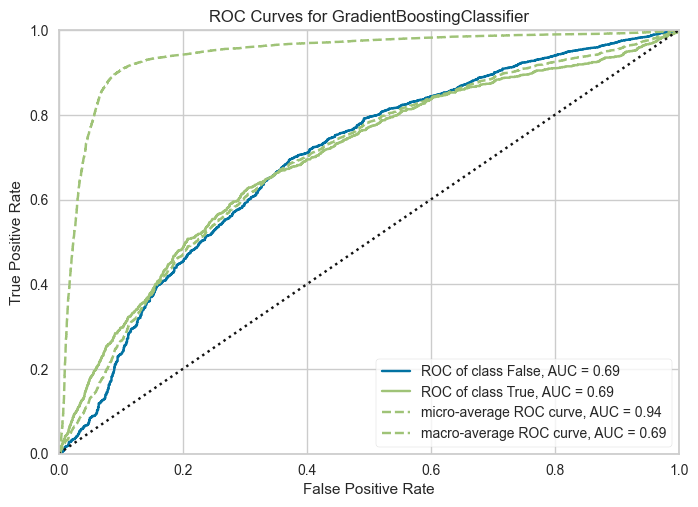

In [20]:
plot_model(tuned_gbc, plot = 'auc')

### 10.2 Precision-Recall Plot

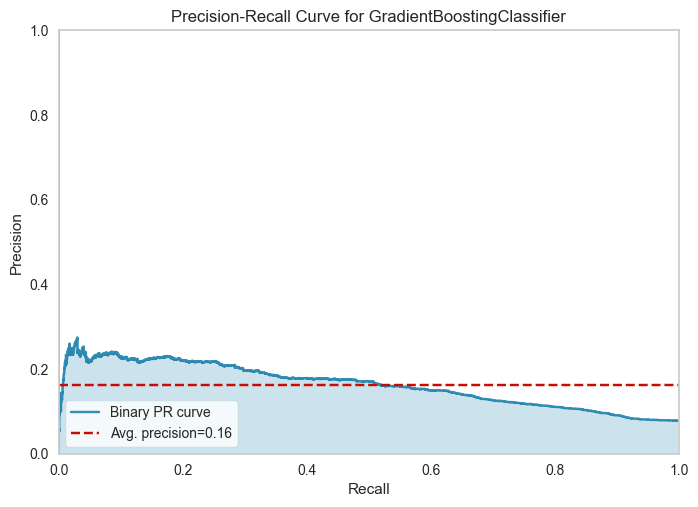

In [21]:
plot_model(tuned_gbc, plot = 'pr')

### 10.3 Importância das variáveis (Feature Importance) Plot

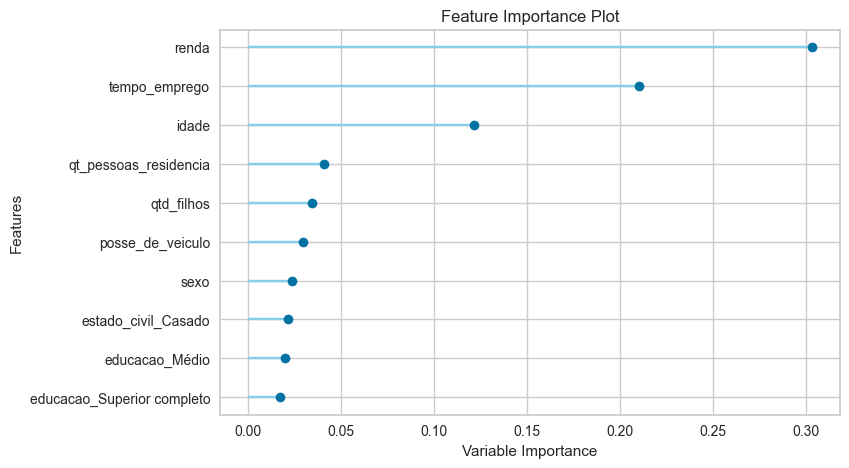

In [22]:
plot_model(tuned_gbc, plot='feature')

### 10.4 Matriz de confusão (Confusion matrix)

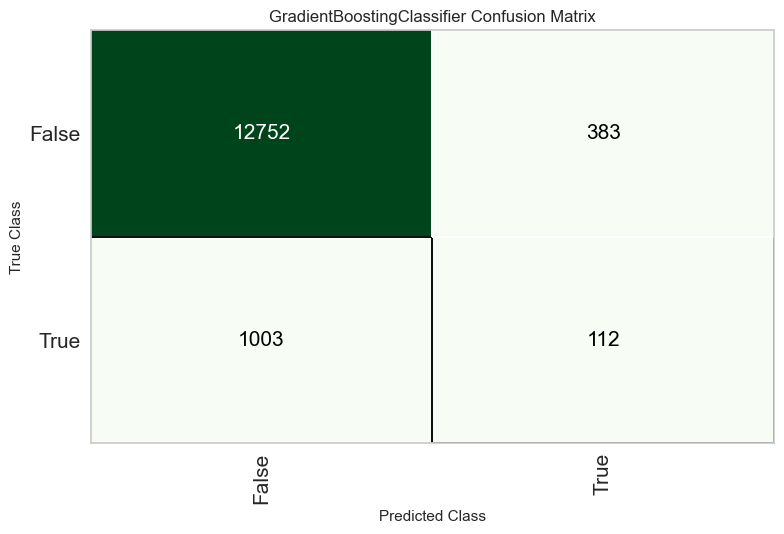

In [23]:
plot_model(tuned_gbc, plot = 'confusion_matrix')

In [24]:
evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Predict na amostra de validação / hold-out

In [25]:
predict_model(tuned_gbc);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9027,0.6941,0.1004,0.2263,0.1391,0.0956,0.1046


# Finalizando o modelo para deploy

In [26]:
final_gbc = finalize_model(tuned_gbc)

In [27]:
#Parâmetros finais do modelo Random Forest para deploy
print(final_gbc)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                            criterion='friedman_mse', init=None,
                   

In [28]:
predict_model(final_gbc);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9159,0.7688,0.1345,0.3916,0.2003,0.1669,0.1939


# Predizendo o conjunto de dados que não foi usado no treino

In [29]:
unseen_predictions = predict_model(final_gbc, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9080,0.6794,0.0732,0.2727,0.1154,0.0836,0.1043


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,N,S,0,Assalariado,Médio,Casado,Casa,42,0.775342,2.0,3865.850098,False,0,0.9235
1,M,S,N,0,Empresário,Médio,Casado,Casa,48,6.805480,2.0,2463.350098,False,0,0.9445
2,F,S,S,0,Assalariado,Superior completo,Casado,Casa,42,13.243835,2.0,62864.558594,False,0,0.9867
3,M,N,N,0,Assalariado,Médio,Casado,Casa,51,23.679453,2.0,8289.169922,False,0,0.9809
4,F,N,S,0,Servidor público,Médio,União,Casa,35,8.912329,2.0,9151.269531,False,0,0.9619


In [30]:
unseen_predictions.dtypes

sexo                     category
posse_de_veiculo         category
posse_de_imovel          category
qtd_filhos                   int8
tipo_renda               category
educacao                 category
estado_civil             category
tipo_residencia          category
idade                        int8
tempo_emprego             float32
qt_pessoas_residencia     float32
renda                     float32
mau                          bool
prediction_label            int32
prediction_score          float64
dtype: object

# Salvando o modelo final

In [37]:
save_model(final_gbc,'model_final_victor_tintel.pkl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                             criterion='friedman_mse', init=None,
    

(DICA: É sempre bom usar data no nome do arquivo ao salvar modelos, é bom para controle de versão.)

# Carregando o modelo salvo

Para carregar um modelo salvo em uma data futura no mesmo ambiente ou em um ambiente alternativo, usaríamos a função `load_model()` do PyCaret e, em seguida, aplicaríamos facilmente o modelo salvo em novos dados não vistos para previsão.

In [38]:
saved_final_gbc = load_model('Final GBC Model 02Jun2022')

Transformation Pipeline and Model Successfully Loaded


Uma vez que o modelo é carregado no ambiente, você pode simplesmente usá-lo para prever quaisquer novos dados usando a mesma função `predict_model()`. Abaixo, aplicamos o modelo carregado para prever o mesmo `data_unseen` que usamos na seção 13 acima.

In [39]:
new_prediction = predict_model(saved_final_gbc, data=data_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9080,0.6794,0.0732,0.2727,0.1154,0.0836,0.1043


In [40]:
new_prediction.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,N,S,0,Assalariado,Médio,Casado,Casa,42,0.775342,2.0,3865.850098,False,0,0.9235
1,M,S,N,0,Empresário,Médio,Casado,Casa,48,6.805480,2.0,2463.350098,False,0,0.9445
2,F,S,S,0,Assalariado,Superior completo,Casado,Casa,42,13.243835,2.0,62864.558594,False,0,0.9867
3,M,N,N,0,Assalariado,Médio,Casado,Casa,51,23.679453,2.0,8289.169922,False,0,0.9809
4,F,N,S,0,Servidor público,Médio,União,Casa,35,8.912329,2.0,9151.269531,False,0,0.9619


In [42]:
saved_final_gbc.named_steps

{'numerical_imputer': TransformerWrapper(exclude=None,
                    include=['qtd_filhos', 'idade', 'tempo_emprego',
                             'qt_pessoas_residencia', 'renda'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
                                              keep_empty_features=False,
                                              missing_values=nan,
                                              strategy='mean')),
 'categorical_imputer': TransformerWrapper(exclude=None,
                    include=['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                             'tipo_renda', 'educacao', 'estado_civil',
                             'tipo_residencia'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
                                              keep_empty_features=False,
